In [1]:
import qiskit
import numpy as np
import random
import matplotlib.pyplot as plt
import json
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import XGate, ZGate
from qiskit import QuantumCircuit
from qiskit_aer.noise import (
    NoiseModel,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
    phase_damping_error,
    ReadoutError,
    RelaxationNoisePass
)
from qiskit_ibm_runtime import QiskitRuntimeService

In [2]:
# Save and load your IBM Quantum account credentials
'''QiskitRuntimeService.save_account(token='2fdf9a0789b4a59bc40442c862e78c1bc79eea8668e6fd2fbcf8218db84742b0d2e16f9f21d6ee4ec0a187493e52637555e892bc7e5184b787d84e844bff7ba2', channel='ibm_quantum', overwrite=True)'''
service = QiskitRuntimeService()

In [3]:
backend = service.backend('ibm_fez')

In [4]:
backend_prop = backend.properties().__dict__

In [5]:
gate_props = backend_prop["_gates"]
gate_error_list = []
for gate_type in gate_props.keys():
    gate_qubits = list(gate_props[gate_type].keys())
    for q in gate_qubits:
        gate_error = gate_props[gate_type][q].get('gate_error', (0,0))[0]
        gate_error_list.append((gate_type, q, gate_error))
gate_error_list

[('id', (0,), 0.001239004291372283),
 ('id', (1,), 0.00028526216065517346),
 ('id', (2,), 0.00013548999250201786),
 ('id', (3,), 0.0002301241894995379),
 ('id', (4,), 0.0002372053963323935),
 ('id', (5,), 0.00017124314718994682),
 ('id', (6,), 0.0003073505013535124),
 ('id', (7,), 0.0004863702464762738),
 ('id', (8,), 0.0005427623526698826),
 ('id', (9,), 0.00023040032354305518),
 ('id', (10,), 0.00010990407571063569),
 ('id', (11,), 0.0001901322461985827),
 ('id', (12,), 0.0002761437746108934),
 ('id', (13,), 0.0001755287432485388),
 ('id', (14,), 0.00026630138866480003),
 ('id', (15,), 0.001608845105567596),
 ('id', (16,), 0.0004493597599245701),
 ('id', (17,), 0.00021218700550595398),
 ('id', (18,), 0.00028500058770647706),
 ('id', (19,), 0.0004972681811928629),
 ('id', (20,), 0.00032071105444361005),
 ('id', (21,), 0.00016220808949253608),
 ('id', (22,), 0.0002364886543136628),
 ('id', (23,), 0.00018562284086605713),
 ('id', (24,), 0.0002458951763057099),
 ('id', (25,), 0.000171455

In [6]:
noise_model = NoiseModel()
for val in gate_error_list:
    gate, qubits, error = val
    dep_error = depolarizing_error(error, len(qubits) )
    noise_model.add_quantum_error(dep_error, [gate], qubits)
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'rx', 'rz', 'rzz', 'sx', 'x']
  Instructions with noise: ['cz', 'sx', 'x', 'id', 'rzz', 'rx']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('id', (7,)), ('id', (8,)), ('id', (9,)), ('

In [7]:
qubit_props = backend_prop["_qubits"]
qubit_error_list = []
for qubit in qubit_props.keys():
    t1 = qubit_props[qubit]['T1'][0]
    t2 = qubit_props[qubit]['T2'][0]
    qubit_error_list.append((qubit, t1, t2))
qubit_error_list

[(0, 5.5502661674231585e-05, 5.765255730434928e-05),
 (1, 0.0001620908326222778, 0.0002813099154058699),
 (2, 0.00019043420605366479, 0.0001542541201978844),
 (3, 0.00022033604360405834, 0.0002710483280051042),
 (4, 0.00018403220840024082, 0.00014836285675353284),
 (5, 0.0001523570329669167, 0.00025536320387338024),
 (6, 8.565902535436256e-05, 0.00014546432131703617),
 (7, 0.00013389472461607612, 5.4153686853979625e-05),
 (8, 0.00010547998546774479, 5.4973314129661346e-05),
 (9, 0.00015118183465372386, 4.5512385755947206e-05),
 (10, 0.00021532488200720577, 0.00021101472901734636),
 (11, 0.0001589745905833606, 8.275047299845527e-05),
 (12, 8.769453255608124e-05, 8.836766493746478e-05),
 (13, 0.00025421265941011676, 0.00019705340553269538),
 (14, 0.00022620795245186404, 9.551488051638734e-05),
 (15, 0.000163534862528979, 0.00014715558987685168),
 (16, 0.00011269713006906272, 0.00011274582876642839),
 (17, 0.00011171666545270478, 0.00012337470480498243),
 (18, 0.00012618085446869414, 6.31

In [8]:
l1 = 1
l2 = 1
t1s =[(1/l1)*x[1] for x in qubit_error_list]
t2s =[(1/l2)*x[2] for x in qubit_error_list]

In [9]:
delay_pass = RelaxationNoisePass(t1s, t2s, dt=1e-9, op_types=[qiskit.circuit.Delay])

In [10]:
shots = 10000
ideal_simulator = AerSimulator(method='matrix_product_state')
ideal_simulator.set_options(shots=shots)
backend_sim = AerSimulator(method='matrix_product_state',
                        noise_model=noise_model)
backend_sim.set_options(shots=shots)
basis_gates = ['cz', 'id', 'x', 'sx', 'rz']

In [11]:
def initialize_superposition_from_bitstrings(bitstrings):
    n_qubits = len(bitstrings[0])
    qc = QuantumCircuit(n_qubits)

    # 중첩 상태에 들어갈 각 상태에 대한 진폭 계산
    state = np.zeros(2**n_qubits, dtype=complex)
    
    # 각 비트열을 2진수에서 정수로 변환하여 해당 상태에 진폭 할당
    for bitstring in bitstrings:
        index = int(bitstring, 2)  # 비트열을 정수로 변환
        state[index] = 1  # 각 상태에 진폭을 1로 설정 (동등한 중첩)

    # 진폭들의 노름이 1이 되도록 정규화
    state /= np.linalg.norm(state)

    # 계산된 중첩 상태로 큐비트 초기화
    qc.initialize(state)
    tqc = transpile(qc, basis_gates=basis_gates, optimization_level=3)
    new_qc = QuantumCircuit(n_qubits)
    for gate in tqc:
        if gate.operation.name == 'reset':
            continue
        new_qc.append(gate)

    return new_qc

def find_always_zero_qubits(bitstrings):
    if not bitstrings:
        return []

    num_qubits = len(bitstrings[0])  # 비트스트링의 길이(큐빗 수)
    always_zero_qubits = []

    for i in range(num_qubits):
        # i번째 위치의 큐빗이 항상 0인지 확인
        if all(bitstring[num_qubits-1-i] == '0' for bitstring in bitstrings):
            always_zero_qubits.append(i)

    return always_zero_qubits

def extract_non_zero_bitstrings(psi, total_qubits):
    bitstrings = []
    num_states = len(psi)  # 전체 상태 벡터의 길이
    
    for i, amplitude in enumerate(psi):
        if np.abs(amplitude) > 1e-10:  # 무시할 수 없는 크기의 상태만 고려 1e-12
            binary_state = f"{i:0{total_qubits}b}"
            bitstrings.append(binary_state)
    
    return bitstrings

def err_grover(n, search_bs, targ_bs):
    if len(search_bs) == 2**n:
        qc_init = QuantumCircuit(n)
        for i in range(n):
            qc_init.h(i)
    else:
        qc_init = initialize_superposition_from_bitstrings(search_bs)
    qc_oracle = QuantumCircuit(n+1)
    for tbs in targ_bs:
        qc_oracle.append(XGate().control(n, ctrl_state=tbs), range(n+1))
    
    qc = QuantumCircuit(n+1, n)
    qc.compose(qc_init, inplace=True)
    qc.x(n)
    qc.h(n)
    
    qc.compose(qc_oracle, inplace=True)
    
    qc.compose(qc_init.inverse(), inplace=True)
    #qc.save_statevector(f'psi')
    tqc = transpile(qc, basis_gates=basis_gates, optimization_level=3)
    for i in range(n):
        tqc.measure(i, i)
    # Run simulator
    result = backend_sim.run(tqc).result()
    counts = result.get_counts(0)
    #print(counts)
    
    #psi = np.array(result.data()[f'psi'])
    #total_qubits = n+1
    #bitstrings_psi = extract_non_zero_bitstrings(psi, total_qubits)
    bitstring_reduce = {}
    max_count = np.max(list(counts.values()))
    for key, count in counts.items():
        if count > max_count/10:
            bitstring_reduce[key] = count
    #print(bitstring_reduce)
    
    always_zero = find_always_zero_qubits(list(bitstring_reduce.keys()))
    #print(always_zero)
    
    for i in range(n):
        qc.x(i)
    
    q_list = list(range(n))
    #print("indices of zero qubits", always_zero)
    # Select the target qubit as the highest-indexed qubit among the remaining qubits
    # outside of oracle range (4) excluded
    q_list = [q for q in q_list if q not in always_zero and q < n]
    #print("reduced diff", q_list)
    if len(q_list) > 1:
        qc.append(ZGate().control(len(q_list)-1), q_list)
    elif len(q_list) == 1:
        qc.z(q_list[0])
    
    for i in range(n):
        qc.x(i)
    
    qc.compose(qc_init, inplace=True)
    
    tqc = transpile(qc, basis_gates=basis_gates, optimization_level=3)
    for i in range(n):
        tqc.measure(i, i)
    # Run simulator
    iresult = ideal_simulator.run(tqc).result()
    icounts = iresult.get_counts(0)
    
    # Run simulator
    result = backend_sim.run(tqc).result()
    err = 0
    counts = result.get_counts(0)
    for key, count in counts.items():
        if key in icounts.keys():
            if icounts[key] > counts[key]:
                err += icounts[key]-counts[key]
    err_rate = err/shots
    print(f'    ideal searched state is[{max(icounts, key=icounts.get)}]')
    print(f'    noised searched state is[{max(counts, key=counts.get)}]')
    
    '''unitary = qi.Operator(qc_init).data
    abs_unitary = np.abs(unitary)'''
    '''abs_unitary = get_unitary_with_abs(qc_init)
    eigenvalues = np.linalg.eigvals(abs_unitary)'''
    
    return len(always_zero), err_rate, icounts, counts, qc_init, tqc

In [12]:
"""err_rate_list = []
num_reduced = []
icounts_list = []
counts_list = []
for n in range(5, 17):
    print('n =', n)
    bitstrings = [f"{i:0{n}b}" for i in range(2**n)]
    err_rate = []
    reduced = []
    icounts1 = []
    counts1 = []
    for iter in range(10):
        bs_search = random.sample(bitstrings, 10)
        bs_targ = random.sample(bs_search, 1)
        print('    target bitstring is', bs_targ)
        res = err_grover(n, bitstrings, bs_targ)
        err_rate.append(res[1])
        reduced.append(res[0])
        icounts1.append(res[2])
        counts1.append(res[3])
    #print('reduced', res[0])
    #print('  error rate is', err_rate/10)
    num_reduced.append(reduced)
    err_rate_list.append(err_rate)
    icounts_list.append(icounts1)
    counts_list.append(counts1)
print('error rates are', err_rate_list)
with open(f'Noise_model_test1.json', 'w') as file:
    json.dump([err_rate_list, num_reduced, icounts_list, counts_list], file)"""

'err_rate_list = []\nnum_reduced = []\nicounts_list = []\ncounts_list = []\nfor n in range(5, 17):\n    print(\'n =\', n)\n    bitstrings = [f"{i:0{n}b}" for i in range(2**n)]\n    err_rate = []\n    reduced = []\n    icounts1 = []\n    counts1 = []\n    for iter in range(10):\n        bs_search = random.sample(bitstrings, 10)\n        bs_targ = random.sample(bs_search, 1)\n        print(\'    target bitstring is\', bs_targ)\n        res = err_grover(n, bitstrings, bs_targ)\n        err_rate.append(res[1])\n        reduced.append(res[0])\n        icounts1.append(res[2])\n        counts1.append(res[3])\n    #print(\'reduced\', res[0])\n    #print(\'  error rate is\', err_rate/10)\n    num_reduced.append(reduced)\n    err_rate_list.append(err_rate)\n    icounts_list.append(icounts1)\n    counts_list.append(counts1)\nprint(\'error rates are\', err_rate_list)\nwith open(f\'Noise_model_test1.json\', \'w\') as file:\n    json.dump([err_rate_list, num_reduced, icounts_list, counts_list], file

In [13]:
"""with open('Noise_model_test1.json', 'r') as file:
    data = json.load(file)
err_rate_list = data[0]
num_reduced = data[1]
plt.errorbar(range(5, 5+len(err_rate_list)), np.mean(err_rate_list, axis=1), yerr=np.std(err_rate_list, axis=1))
plt.xlabel('# of qubits')
plt.ylabel('error rate')
plt.show()

plt.errorbar(range(5, 5+len(num_reduced)), np.mean(num_reduced, axis=1), yerr=np.std(num_reduced, axis=1))
plt.xlabel('# of qubits')
plt.ylabel('# of reduced qubit')
plt.show()"""

"with open('Noise_model_test1.json', 'r') as file:\n    data = json.load(file)\nerr_rate_list = data[0]\nnum_reduced = data[1]\nplt.errorbar(range(5, 5+len(err_rate_list)), np.mean(err_rate_list, axis=1), yerr=np.std(err_rate_list, axis=1))\nplt.xlabel('# of qubits')\nplt.ylabel('error rate')\nplt.show()\n\nplt.errorbar(range(5, 5+len(num_reduced)), np.mean(num_reduced, axis=1), yerr=np.std(num_reduced, axis=1))\nplt.xlabel('# of qubits')\nplt.ylabel('# of reduced qubit')\nplt.show()"

In [14]:
num_search_list = []
num_targ_list = []
num_bitstring = []
err_list = []
reduced_list = []
ratio_search = []
init_qc = []
tqc = []
for n in range(5, 7):
    bitstrings = [f"{i:0{n}b}" for i in range(2**n)]
    for num_targ in range(1, 3):
        for num_search in range(2, 4*n, 4):
            bs_search = random.sample(bitstrings, num_search)
            err_list_iter = []
            reduced_list_iter = []
            for iter in range(5):
                res = err_grover(n, bs_search, random.sample(bs_search, num_targ))
                err_list.append(res[1])
                reduced_list.append(res[0])
                num_search_list.append(num_search)
                num_targ_list.append(num_targ)
                num_bitstring.append(2**n)
                ratio_search.append(num_search/2**n)
                init_qc.append(res[4])
                tqc.append(res[5])

    ideal searched state is[01111]
    noised searched state is[01001]
    ideal searched state is[01111]
    noised searched state is[01001]
    ideal searched state is[01111]
    noised searched state is[01001]
    ideal searched state is[01111]
    noised searched state is[01111]
    ideal searched state is[01111]
    noised searched state is[01001]
    ideal searched state is[11001]
    noised searched state is[11001]
    ideal searched state is[10100]
    noised searched state is[10100]
    ideal searched state is[10100]
    noised searched state is[10100]
    ideal searched state is[00001]
    noised searched state is[00001]
    ideal searched state is[10010]
    noised searched state is[10010]
    ideal searched state is[00110]
    noised searched state is[00000]
    ideal searched state is[01001]
    noised searched state is[00000]
    ideal searched state is[10100]
    noised searched state is[00001]
    ideal searched state is[01111]
    noised searched state is[01111]
    id

In [15]:
"""len_tqc = []
for i in range(len(init_qc)):
    '''num_2q = 0
    for j in range(len(tqc[i])):
        if tqc[i][j].operation.num_qubits == 2:
            num_2q += 1'''
    len_tqc.append(len(tqc[i]))

x1 = reduced_list[:15]
x2 = len_tqc[:15]
x3 = err_list[:15]

plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
plt.scatter(x1, x2)
plt.xlabel('# reduced qubit', fontsize=15, labelpad=10)
plt.ylabel('depth', fontsize=15, labelpad=10)
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
plt.grid(False)

plt.subplot(1, 3, 2)
plt.title('when # of target bitstring is 2')
plt.scatter(x1, x3)
plt.xlabel('# reduced qubit', fontsize=15, labelpad=10)
plt.ylabel('error rate', fontsize=15, labelpad=10)
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
plt.grid(False)

plt.subplot(1, 3, 3)
plt.scatter(x2, x3)
plt.xlabel('depth', fontsize=15, labelpad=10)
plt.ylabel('error rate', fontsize=15, labelpad=10)
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
plt.grid(False)

plt.subplots_adjust(wspace=0.3)

plt.show()"""

"len_tqc = []\nfor i in range(len(init_qc)):\n    '''num_2q = 0\n    for j in range(len(tqc[i])):\n        if tqc[i][j].operation.num_qubits == 2:\n            num_2q += 1'''\n    len_tqc.append(len(tqc[i]))\n\nx1 = reduced_list[:15]\nx2 = len_tqc[:15]\nx3 = err_list[:15]\n\nplt.figure(figsize=(12, 3))\n\nplt.subplot(1, 3, 1)\nplt.scatter(x1, x2)\nplt.xlabel('# reduced qubit', fontsize=15, labelpad=10)\nplt.ylabel('depth', fontsize=15, labelpad=10)\nfor spine in plt.gca().spines.values():\n    spine.set_edgecolor('black')\nplt.grid(False)\n\nplt.subplot(1, 3, 2)\nplt.title('when # of target bitstring is 2')\nplt.scatter(x1, x3)\nplt.xlabel('# reduced qubit', fontsize=15, labelpad=10)\nplt.ylabel('error rate', fontsize=15, labelpad=10)\nfor spine in plt.gca().spines.values():\n    spine.set_edgecolor('black')\nplt.grid(False)\n\nplt.subplot(1, 3, 3)\nplt.scatter(x2, x3)\nplt.xlabel('depth', fontsize=15, labelpad=10)\nplt.ylabel('error rate', fontsize=15, labelpad=10)\nfor spine in plt.g

In [16]:
result = {'ratio_search': ratio_search, 'reduced_list': reduced_list, 'err_list': err_list, 'num_search_list': num_search_list, 'num_bitstring': num_bitstring}
with open(f'Noise_model_test2.json', 'w') as file:
    json.dump(result, file)

In [17]:
with open('Noise_model_test2.json', 'r') as file:
    sim_data = json.load(file)
"""ratio_search2 = sim_data['ratio_search'][:50] + sim_data['ratio_search'][100:160]
reduced_list2 = sim_data['reduced_list'][:50] + sim_data['reduced_list'][100:160]
err_list2 = sim_data['err_list'][:50] + sim_data['err_list'][100:160]"""

ratio_search2 = sim_data['ratio_search']# + sim_data['ratio_search'][160:]
reduced_list2 = sim_data['reduced_list']# + sim_data['reduced_list'][160:]
err_list2 = sim_data['err_list']# + sim_data['err_list'][160:]

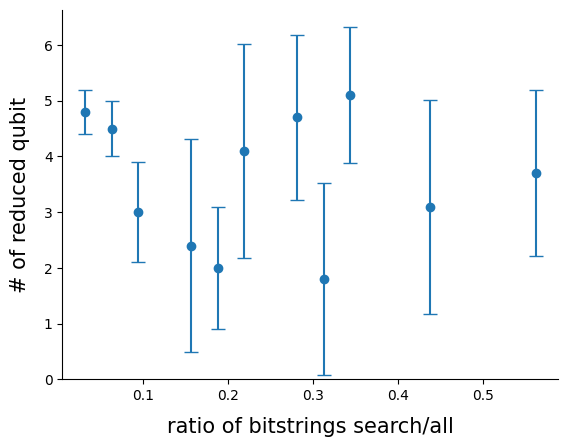

In [18]:
from collections import defaultdict

# 동일한 ratio_search 값을 가진 데이터를 묶기 위해 defaultdict 사용
data = defaultdict(list)

# ratio_search 값에 따라 reduced_list 값을 그룹화
for r, val in zip(ratio_search2, reduced_list2):
    data[r].append(val)

# 각 ratio_search 값에 대해 평균과 표준편차 계산
x_vals = []
y_means = []
y_stds = []

for r, values in data.items():
    x_vals.append(r)
    y_means.append(np.mean(values))
    y_stds.append(np.std(values))

# errorbar 플롯 그리기
plt.errorbar(x_vals, y_means, yerr=y_stds, fmt='o', capsize=5)

plt.ylim(0)
plt.xlabel("ratio of bitstrings search/all", fontsize=15, labelpad=10)
plt.ylabel("# of reduced qubit", fontsize=15, labelpad=10)

for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(False)

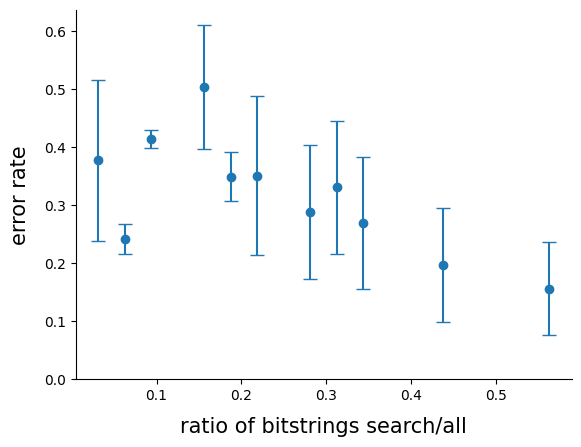

In [19]:
from collections import defaultdict

# 동일한 ratio_search 값을 가진 데이터를 묶기 위해 defaultdict 사용
data = defaultdict(list)

# ratio_search 값에 따라 reduced_list 값을 그룹화
for r, val in zip(ratio_search2, err_list2):
    data[r].append(val)

# 각 ratio_search 값에 대해 평균과 표준편차 계산
x_vals = []
y_means = []
y_stds = []

for r, values in data.items():
    x_vals.append(r)
    y_means.append(np.mean(values))
    y_stds.append(np.std(values))

# errorbar 플롯 그리기
plt.errorbar(x_vals, y_means, yerr=y_stds, fmt='o', capsize=5)

plt.ylim(0)
plt.xlabel("ratio of bitstrings search/all", fontsize=15, labelpad=10)
plt.ylabel("error rate", fontsize=15, labelpad=10)

for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(False)

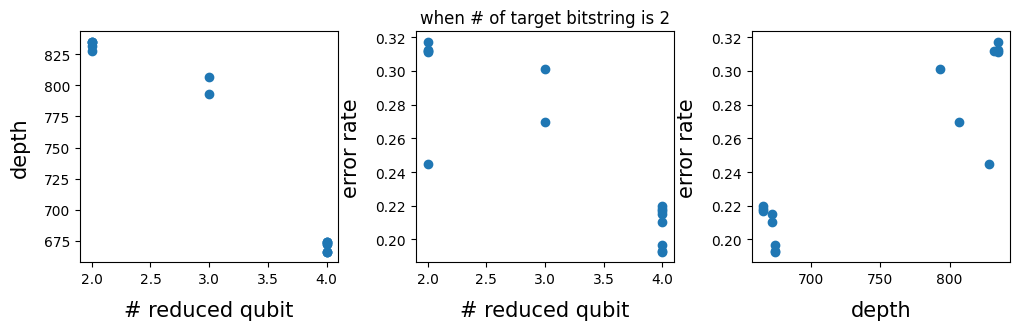

In [20]:
len_tqc = []
for i in range(len(init_qc)):
    '''num_2q = 0
    for j in range(len(tqc[i])):
        if tqc[i][j].operation.num_qubits == 2:
            num_2q += 1'''
    len_tqc.append(len(tqc[i]))

x1 = reduced_list[:15]
x2 = len_tqc[:15]
x3 = err_list[:15]

plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
plt.scatter(x1, x2)
plt.xlabel('# reduced qubit', fontsize=15, labelpad=10)
plt.ylabel('depth', fontsize=15, labelpad=10)
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
plt.grid(False)

plt.subplot(1, 3, 2)
plt.title('when # of target bitstring is 2')
plt.scatter(x1, x3)
plt.xlabel('# reduced qubit', fontsize=15, labelpad=10)
plt.ylabel('error rate', fontsize=15, labelpad=10)
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
plt.grid(False)

plt.subplot(1, 3, 3)
plt.scatter(x2, x3)
plt.xlabel('depth', fontsize=15, labelpad=10)
plt.ylabel('error rate', fontsize=15, labelpad=10)
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
plt.grid(False)

plt.subplots_adjust(wspace=0.3)

plt.show()